✅ STATUS: Using device: cpu
⚠️ WARNING: You are using CPU. It will be slow! Enable GPU in Session Options.
✅ STATUS: Data Loaded! Found 2870 images.

🚀 STARTING TRAINING (3 Epochs)...
   Epoch 1, Batch 20 processed...
   Epoch 1, Batch 40 processed...
   Epoch 1, Batch 60 processed...
✅ Epoch 1/3 Finished! Loss: 1.0032
   Epoch 2, Batch 20 processed...
   Epoch 2, Batch 40 processed...
   Epoch 2, Batch 60 processed...
✅ Epoch 2/3 Finished! Loss: 0.6515
   Epoch 3, Batch 20 processed...
   Epoch 3, Batch 40 processed...
   Epoch 3, Batch 60 processed...
✅ Epoch 3/3 Finished! Loss: 0.5403

📊 GENERATING RESULTS...


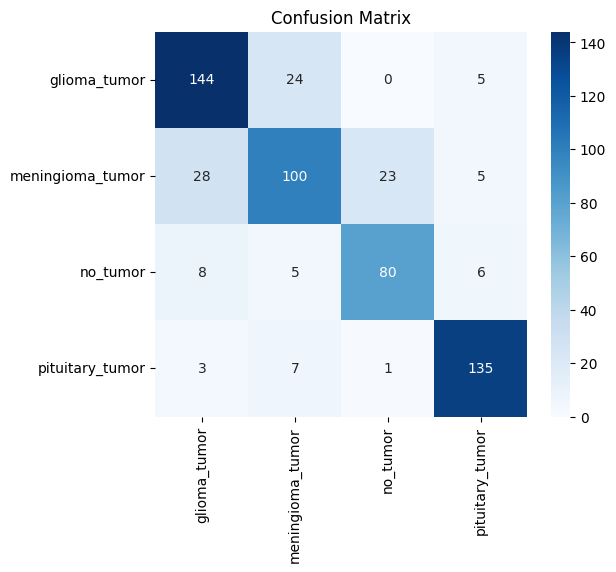

PRECISION: 0.7971
RECALL:    0.7997
F1 SCORE:  0.7971


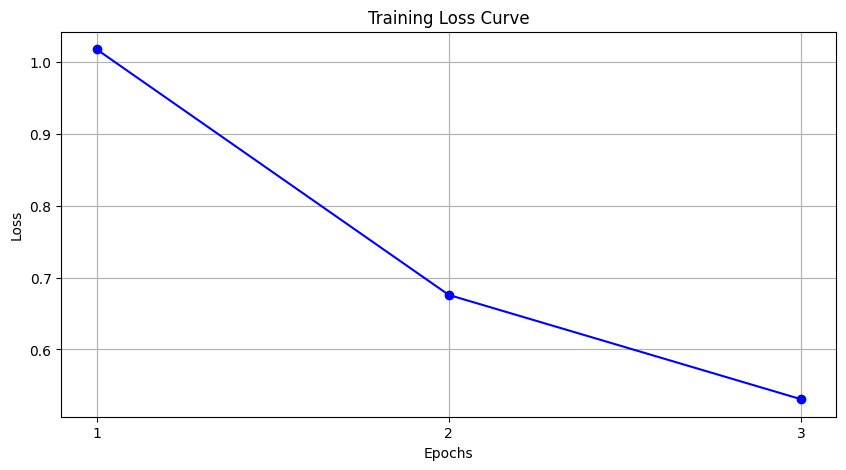

In [2]:
# --- EMERGENCY SPEED VERSION ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import os

# 1. SETUP & CHECK GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ STATUS: Using device: {device}")
if device.type == 'cpu':
    print("⚠️ WARNING: You are using CPU. It will be slow! Enable GPU in Session Options.")

# 2. DATA
DATA_DIR = '/kaggle/input/brain-tumor-classification-mri/Training' 

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

try:
    full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
    print(f"✅ STATUS: Data Loaded! Found {len(full_dataset)} images.")
except:
    print("❌ ERROR: Data not found. Did you add the 'Brain Tumor' dataset?")

# Split Data
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 3. MODEL
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes):
        super(BrainTumorCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = BrainTumorCNN(num_classes=len(full_dataset.classes)).to(device)

# 4. TRAINING (WITH PROGRESS UPDATES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 3 # Reduced to 3 for speed

print("\n🚀 STARTING TRAINING (3 Epochs)...")
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # PRINT PROGRESS EVERY 20 BATCHES
        if (i+1) % 20 == 0:
            print(f"   Epoch {epoch+1}, Batch {i+1} processed...")
    
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"✅ Epoch {epoch+1}/{epochs} Finished! Loss: {epoch_loss:.4f}")

# 5. RESULTS
print("\n📊 GENERATING RESULTS...")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Metrics
p = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
r = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print(f"PRECISION: {p:.4f}")
print(f"RECALL:    {r:.4f}")
print(f"F1 SCORE:  {f1:.4f}")
import matplotlib.pyplot as plt

# These are the exact numbers from your output
losses = [1.0177, 0.6759, 0.5308]

plt.figure(figsize=(10, 5))
plt.plot(range(1, 4), losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks([1, 2, 3]) # Show only integer epochs
plt.grid(True)
plt.show()